## Notebook extensions

Allows for real-time modules' code update

In [87]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
%autoreload 2

## Prerequisites

The libraries that are needed in order for the project to work

In [89]:
import numpy as np # Working with tensors

In [90]:
import silero_vad # Fast VAD

In [91]:
import sounddevice # Recording audio

In [92]:
import matplotlib.pyplot as plt # Data visualization

In [93]:
import seaborn as sns # For easier visualization in certain places

In [94]:
import os # Managing dataset files

In [95]:
import librosa # Audio processing

In [96]:
import pandas as pd # For dataframes

In [97]:
import tensorflow as tf # NN framework

In [98]:
import keras.layers

In [99]:
from tqdm.notebook import tqdm # Progress bars

In [100]:
import sklearn # Contains useful utilities for working with the model

In [101]:
import audiomentations # Audio augmentations

In [102]:
from IPython.display import Audio # For an audio widget inside of the notebook

In [103]:
from types import MappingProxyType # Immutable dictionary

In [104]:
import scipy # Contains signal filters

In [105]:
import soundfile as sf

In [106]:
import sys # To import modules of the parent folder

## Custom modules

In [107]:
sys.path.append('../')
from config import Config # Configuration variables
import processing

## Dataset-related constants

In [108]:
STR_TO_EMOTION = MappingProxyType({
    '01': 'neutral',
    '03': 'happy',
    '05': 'angry',
    '08': 'surprise',
    '04': 'sad',
    
    '02': 'neutral', # Calm considered as neutral to expand the dataset 
    # '06': 'fearful', Excluded for compatibility
    # '07': 'disgust',
})

STR_TO_INTENSITY = MappingProxyType({
    '01': 'normal',
    '02': 'strong',
})

def get_speaker_gender(str):
    return 'female' if int(str) % 2 == 0  else 'male'

## Configuration

In [109]:
cfg = Config() # Values inside config.py are used by default

In [110]:
vad_model = silero_vad.load_silero_vad()

## Dataset preprocessing

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

> The dataset has been downloaded as a .zip archive from
>
>
> https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio/data
>
>
> Folders Actor 1 ... 24 were then unpacked to the `./research/dataset/RAVDESS` directory of the project

Kun Zhou, Berrak Sisman, Rui Liu and Haizhou Li, "Seen and unseen emotional style transfer for voice conversion with a new emotional speech dataset" ICASSP 2021-2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)

> The dataset has been downloaded as a .zip archive from
>
>
> https://github.com/HLTSingapore/Emotional-Speech-Data
>
>
> Folders 0001...0020 were then unpacked to the `./research/dataset/ESD` directory of the project

### Loading the information

In [111]:
dataset_information = pd.DataFrame(columns=['filepath', 'emotion'])

In [112]:
for dirname, _, filenames in os.walk('./dataset/RAVDESS'):
    for filename in filenames:
        if filename == '.gitignore': continue
        params = filename[:-4].split('-')
        if params[2] not in ['06', '07']:
            dataset_information.loc[len(dataset_information)] = [os.path.join(dirname, filename),  
                                                                 STR_TO_EMOTION[params[2]]]

folder_by_speaker = []

for dirname in os.listdir('./dataset/ESD'):
    if dirname == '.gitignore': continue
    folder_by_speaker.append(dirname)

folder_by_emotion = ['Surprise', 'Neutral', 'Happy', 'Sad', 'Angry']

for speaker_folder in folder_by_speaker:
    for emotion_folder in folder_by_emotion:
        for filename in os.listdir(f'./dataset/ESD/{speaker_folder}/{emotion_folder}'):
            if (filename[0] == '.'): continue
            dataset_information.loc[len(dataset_information)] = [f'./dataset/ESD/{speaker_folder}/{emotion_folder}/{filename}', emotion_folder.lower()]

In [113]:
dataset_information.sample(10)

,filepath,emotion
28316,./dataset/ESD/0010/Happy/0010_000937.wav,happy
8870,./dataset/ESD/0009/Happy/0009_000931.wav,happy
14086,./dataset/ESD/0011/Happy/0011_000923.wav,happy
19271,./dataset/ESD/0003/Happy/0003_000871.wav,happy
31702,./dataset/ESD/0013/Happy/0013_000704.wav,happy
22175,./dataset/ESD/0014/Surprise/0014_001599.wav,surprise
22548,./dataset/ESD/0014/Neutral/0014_000272.wav,neutral
3374,./dataset/ESD/0020/Neutral/0020_000221.wav,neutral
32691,./dataset/ESD/0005/Surprise/0005_001418.wav,surprise
29081,./dataset/ESD/0004/Surprise/0004_001591.wav,surprise


Checking if the dataset is balanced across the classes:

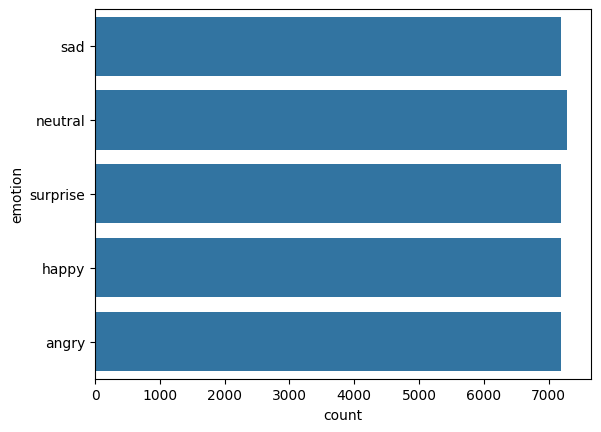

In [114]:
_ = sns.countplot(dataset_information['emotion']) # How many samples of each emotion are there

> Good so far

### Processing functions

In [29]:
def preprocess(data, cfg, original_sr):
    vad_result = silero_vad.get_speech_timestamps(data, vad_model, return_seconds=False)

    voice_data = []
    
    for voice_detection in vad_result:
        voice_data.append(data[voice_detection['start']:voice_detection['end']])

    if not voice_data: return None
    
    result = np.hstack(voice_data)
    
    if len(result) < cfg.input_size: return None
    
    # result = librosa.effects.preemphasis(result)    
    
    # b, a = scipy.signal.butter(5, 25 / cfg.sr, 'high') # A highpass filter with 20Hz cutoff frequency 
    # result = scipy.signal.filtfilt(b, a, result, method='gust', axis=0) # Gust method works better than the default one

    res_max = np.abs(result).max() # Data normalization
    result = (result) / (res_max)
    
    return result

### Observing the data

In [30]:
unique_label_samples = dataset_information.sample(frac=1).drop_duplicates(subset=['emotion']) # Random sample of each emotion from the dataset
unique_label_samples

,filepath,emotion
6196,./dataset/ESD/0018/Angry/0018_000591.wav,angry
22866,./dataset/ESD/0014/Happy/0014_000775.wav,happy
34730,./dataset/ESD/0012/Neutral/0012_000155.wav,neutral
8364,./dataset/ESD/0009/Surprise/0009_001748.wav,surprise
32197,./dataset/ESD/0013/Sad/0013_001051.wav,sad


In [85]:
def make_plots(title, cfg, data):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    
    fig.suptitle(title)
    fig.set_size_inches(10, 2.5)
    
    ax[0].set(title='Time-ampitude')
    ax[1].set(title='Mel')
    ax[2].set(title='MFCC')

    feature_mel = librosa.feature.melspectrogram(y=data, sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    feature_mfcc = librosa.feature.mfcc(y=data, sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    
    time_amplitude = librosa.display.waveshow(y=data, sr=sr, ax=ax[0], color='purple', transpose = False) # Color is explicitly specified to avoid librosa's bug    
    mel = librosa.display.specshow(data=librosa.power_to_db(feature_mel), sr=cfg.sr, ax=ax[1], x_axis='time', y_axis='mel')
    mfcc = librosa.display.specshow(data=feature_mfcc, sr=sr, ax=ax[2], x_axis='time')
    
    fig.tight_layout()

In [86]:
stop_after = 5 # Show for each emotion by default

for index, sample in unique_label_samples.iterrows():
    stop_after -= 1
    if stop_after < 0: break

    data, sr = librosa.load(sample.filepath, sr=cfg.sr)
    
    make_plots(f'Before preprocessing | {sample.emotion}', cfg, data)
    make_plots(f'After preprocessing | {sample.emotion}', cfg, preprocess(data, cfg, cfg.sr))

NameError: name 'unique_label_samples' is not defined

In [33]:
listen_sample_data, _ = librosa.load(dataset_information.sample(1).iloc[0].filepath, sr=cfg.sr)

In [34]:
Audio(listen_sample_data, rate=cfg.sr) # Before preprocessing

In [35]:
Audio(preprocess(listen_sample_data, cfg, cfg.sr), rate=cfg.sr) # After preprocessing

### Class balancing

In [36]:
dataset_already_processed = len(os.listdir('processed')) != 0

In [37]:
labels = set()

In [38]:
[labels.add(label) for label in STR_TO_EMOTION.values()]

[None, None, None, None, None, None]

In [39]:
class_distribution = pd.Series(index=list(labels), data=[0]*len(labels))

In [40]:
class_distribution

surprise    0
sad         0
happy       0
angry       0
neutral     0
dtype: int64

In [41]:
samples = dict(zip(list(labels), [[], [], [], [], []]))

In [42]:
if not dataset_already_processed:
    for _, sample in tqdm(dataset_information.iterrows(), total=dataset_information.shape[0], desc='Loading and preprocessing the dataset now'):
        data, sr = librosa.load(sample.filepath, sr=cfg.sr)
        data = preprocess(data, cfg, original_sr=cfg.sr)
        
        if data is not None:
            class_distribution[sample.emotion] += len(data)
            samples[sample.emotion].append(data)

Loading and preprocessing the dataset now:   0%|          | 0/36056 [00:00<?, ?it/s]

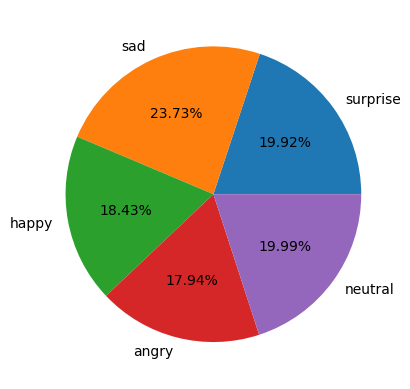

In [43]:
if not dataset_already_processed:
    _ = plt.pie(class_distribution, labels=class_distribution.index, autopct='%.2f%%')

> To balance the classes out random sampling will be performed using inverse distribution. Different augmentations will be picked out at random, and more diverse augmentations are to be applied to less common labels across the preprocessed data.

In [44]:
rebalance_coefficients = class_distribution.max() / class_distribution
print(rebalance_coefficients)

surprise    1.191294
sad         1.000000
happy       1.287655
angry       1.322489
neutral     1.186677
dtype: float64


### Data Augmentation

> Impulse Responses from  https://mcdermottlab.mit.edu/Reverb/IR_Survey.html
> 
> Should be copied under the directory of `./research/impulse_responses`

In [53]:
augment = audiomentations.Compose([
    # audiomentations.RepeatPart(mode='replace', p=1.0), # May add in extra silence if the starting part is repeated
    audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=1.0),
    audiomentations.AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.01, p=1.0),
    # audiomentations.AddColorNoise(p=1.0),
    audiomentations.LowPassFilter(p=1.0),
    audiomentations.HighPassFilter(p=1.0),
    audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=1.0),
])

In [57]:
Audio(augment(samples=np.array(samples['angry'][20]), sample_rate=cfg.sr), rate=cfg.sr) # Augmentation playground

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h242_Classroom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(


In [58]:
samples_per_class = 500

In [59]:
if not dataset_already_processed:
    augmentation_failed = 0
    
    for emotion in samples:
        p_increase = rebalance_coefficients[emotion] / 10
        augment = audiomentations.Compose([
            audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=0.1),
            audiomentations.AddGaussianNoise(min_amplitude=0.01, max_amplitude=0.01, p=0.2),
            audiomentations.LowPassFilter(p=0.2),
            audiomentations.HighPassFilter(p=0.2),
            audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=0.1),
        ])
        
        for i in tqdm(range(samples_per_class), desc=emotion):
            random_index = np.random.randint(0, len(samples[emotion]))
            try:
                sf.write(f'processed/{emotion}_{i}.wav', augment(samples=np.array(samples[emotion][random_index]), sample_rate=cfg.sr), cfg.sr)
            except Exception as e:
                sf.write(f'processed/{emotion}_{i}.wav', np.array(samples[emotion][random_index]), cfg.sr)
                augmentation_failed += 1
                print(e)

    print(f'Augmentation failed {augmentation_failed} times during the whole process')

surprise:   0%|          | 0/500 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h232_Hallway_MITCampus_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h070_Outdoor_MITBrickAmpitheater_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h086_Bar_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses

sad:   0%|          | 0/500 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h143_Outside_StreetsOfBoston_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h180_Outside_Field_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h057_Outside_SuburbanDriveway_3txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impu

happy:   0%|          | 0/500 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h035_Bar_LargeSportsBar_5txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h066_MITCampus_StudentLounge_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h250_Classroom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_respon

angry:   0%|          | 0/500 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h198_Hallway_MITCampus_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h212_Outside_StreetsOfSomerville_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h045_Livingroom_4txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_re

neutral:   0%|          | 0/500 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h024_Bathroom_9txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h262_Classroom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h015_Bedroom_174txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h083_Outside_Parking

Augmentation failed 0 times during the whole process


/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h245_Classroom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h172_Outside_EntranceOfLexingtonPublicLibrary_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(


## Training the model

> Validation is combined with the training step

In [25]:
X, Y = [], []

In [26]:
for file in tqdm(os.listdir('processed'), desc='Calculating the features'):
    if 'wav' not in file: continue
    data, sr = librosa.load('processed/' + file)
    for i in range(0, len(data) - cfg.input_size, cfg.input_size):
        # feature_mfcc = librosa.feature.mfcc(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=32, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
        # X.append(feature_mfcc)

        feature_mel = librosa.feature.melspectrogram(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
        
        X.append(np.swapaxes(feature_mel, 0, 1))
        Y.append(file.split('_')[0])

Calculating the features:   0%|          | 0/2500 [00:00<?, ?it/s]

<Axes: xlabel='count'>

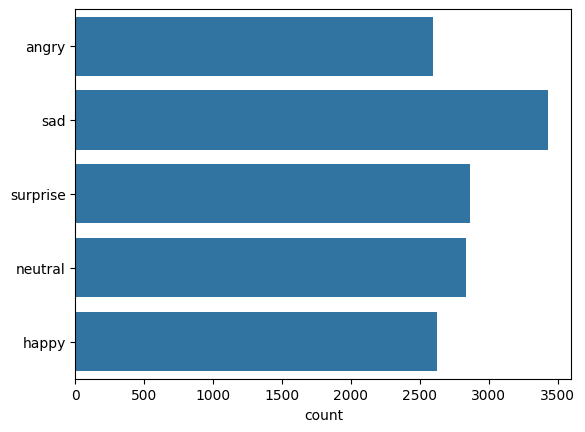

In [27]:
sns.countplot(Y)

> Labels for sadness are a little abundant compared to the other ones

In [52]:
classes = np.unique(Y)

In [53]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=classes, y=Y)

In [54]:
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [55]:
onehot_enc = tf.keras.utils.to_categorical([i for i in range(len(classes))])

In [56]:
onehot_map = {classes: encoding for classes, encoding in zip(classes, onehot_enc)}

In [57]:
print(onehot_map)

{'angry': array([1., 0., 0., 0., 0.]), 'happy': array([0., 1., 0., 0., 0.]), 'neutral': array([0., 0., 1., 0., 0.]), 'sad': array([0., 0., 0., 1., 0.]), 'surprise': array([0., 0., 0., 0., 1.])}


In [34]:
from sklearn.model_selection import train_test_split

> Note that train_test_split() already shuffles all the data by default

In [35]:
X_train, X_val_test, Y_train, Y_val_test = train_test_split(X, [onehot_map[Y] for Y in Y], test_size=0.3) # 30% - for validation and test sets

In [36]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_test, Y_val_test, test_size=0.5) # 15% for validation and 15% for test (50% of 30%)

In [37]:
input_shape = np.array(X_train).shape

In [50]:
print(np.array(Y_train).shape)

(10047, 5)


In [51]:
print(input_shape)

(10047, 84, 128)


In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape[1:])),
model.add(tf.keras.layers.LSTM(196, return_sequences=True)),
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128, activation='relu')))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(64, activation='relu')))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(16, activation='relu')))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(5, activation='softmax'))

2024-12-18 18:42:56.997407: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [41]:
#
# CNN-based approach
#
#model = tf.keras.Sequential()
#model.add(tf.keras.layers.Input(shape=np.expand_dims(X_train, -1).shape[1:]))
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
#model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
#model.add(tf.keras.layers.Dropout(0.2))
#model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
#model.add(tf.keras.layers.MaxPool2D((2,2)))
#model.add(tf.keras.layers.Dropout(0.3))
#model.add(tf.keras.layers.Flatten())
#model.add(tf.keras.layers.BatchNormalization())
#model.add(tf.keras.layers.Dense(128, activation='relu'))
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [42]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 84, 196)        │       254,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 84, 196)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 84, 128)        │        25,216 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 84, 64)         │         8,256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 84, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 84, 16)         │         1,040 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1344)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         6,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 296,037 (1.13 MB)

 Trainable params: 296,037 (1.13 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
import time, datetime
timestamp_str = '-'.join(str(datetime.datetime.fromtimestamp(time.time())).split())
print(f'../models/emvoia-{timestamp_str}.keras')

../models/emvoia-2024-12-18-18:54:20.271631.keras


In [62]:
X_val = np.array(X_val)
Y_val = np.array(Y_val)

In [63]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../models/emvoia-{timestamp_str}.keras', monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False)

In [65]:
history = model.fit(np.array(X_train), np.array(Y_train), epochs=10, batch_size=128, verbose=1, class_weight=class_weights, validation_data=(X_val, Y_val), callbacks=[checkpoint])

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - acc: 0.3324 - loss: 1.4497
Epoch 1: val_acc improved from -inf to 0.31863, saving model to ../models/emvoia-2024-12-18-18:54:20.271631.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 49s 621ms/step - acc: 0.3324 - loss: 1.4497 - val_acc: 0.3186 - val_loss: 1.4605
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 545ms/step - acc: 0.3508 - loss: 1.4159
Epoch 2: val_acc improved from 0.31863 to 0.34649, saving model to ../models/emvoia-2024-12-18-18:54:20.271631.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 44s 562ms/step - acc: 0.3509 - loss: 1.4159 - val_acc: 0.3465 - val_loss: 1.4368
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 562ms/step - acc: 0.3953 - loss: 1.3662
Epoch 3: val_acc improved from 0.34649 to 0.35532, saving model to ../models/emvoia-2024-12-18-18:54:20.271631.keras
79/79 ━━━━━━━━━━━━━━━━━━━━ 46s 578ms/step - acc: 0.3952 - loss: 1.3663 - val_acc: 0.3553 - val_loss: 1.4193
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 653ms/step - acc: 0.4172 - loss: 1.3390
Epoc

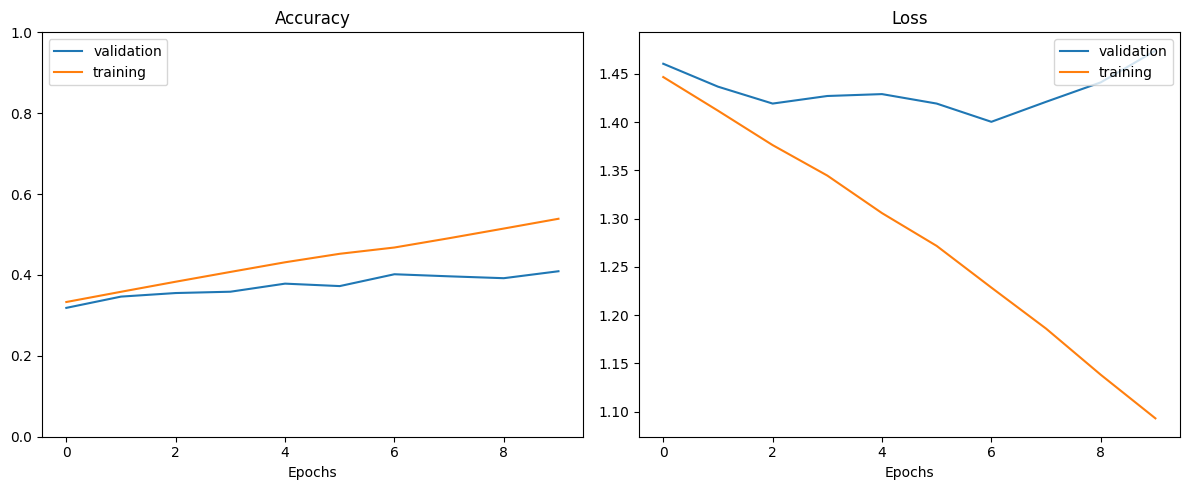

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(12, 5)

ax[0].set(title='Accuracy', xlabel='Epochs')
ax[1].set(title='Loss', xlabel='Epochs')

plt.sca(ax[0])
plt.ylim(0, 1)

val_acc = ax[0].plot(history.history['val_acc'], label='validation')
train_acc = ax[0].plot(history.history['acc'], label='training')

val_loss = ax[1].plot(history.history['val_loss'], label='validation')
train_loss = ax[1].plot(history.history['loss'], label='training')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')

fig.tight_layout()

In [70]:
def onehot_to_emotion(array):
    return list(onehot_map)[np.argmax(array)]

In [71]:
def predict(input):
    return model.predict(np.expand_dims(input, axis=0), verbose=0)

In [76]:
def confusion_matrix(confusion_matrix_counter):
    confusion_matrix = pd.DataFrame(confusion_matrix_counter / confusion_matrix_counter.sum(axis=1), columns=classes, index=classes)
    ax = sns.heatmap(pd.DataFrame(confusion_matrix, columns=classes, index=classes), annot=True, vmin=0, vmax=1, fmt='.2f', linewidths=0.1, linecolor='black')
    plt.ylabel('True classes')
    plt.xlabel('Model predictions')
    plt.tight_layout()
    _ = ax.set(title='Confusion matrix')

## Validation

In [79]:
confusion_matrix_counter_for_val = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [80]:
for i in tqdm(range(len(X_val)), desc='Predicting validation labels'):
    x, y = np.argmax(Y_val[i]), np.argmax(predict(X_val[i]))
    confusion_matrix_counter_for_val[x, y] += 1

Predicting validation labels:   0%|          | 0/2153 [00:00<?, ?it/s]

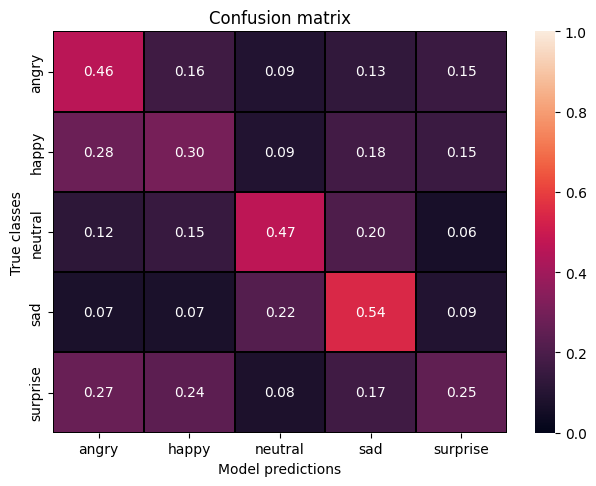

In [81]:
confusion_matrix(confusion_matrix_counter_for_val)

## Test

In [82]:
confusion_matrix_counter_for_test = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [83]:
for i in tqdm(range(len(X_test)), desc='Predicting test labels'):
    x, y = np.argmax(Y_test[i]), np.argmax(predict(X_test[i]))
    confusion_matrix_counter_for_test[x, y] += 1

Predicting test labels:   0%|          | 0/2154 [00:00<?, ?it/s]

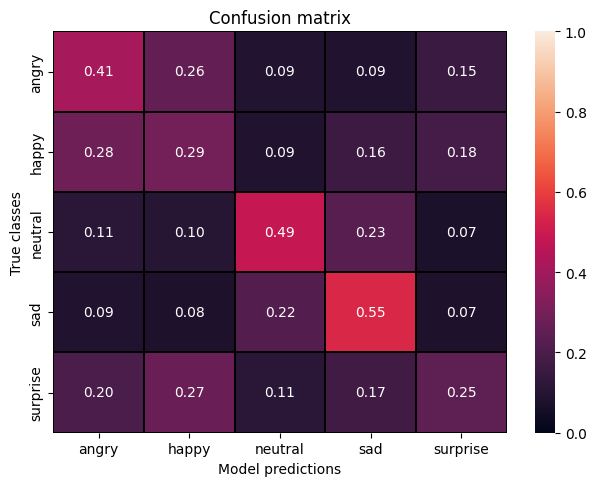

In [84]:
confusion_matrix(confusion_matrix_counter_for_test)